<Body>   
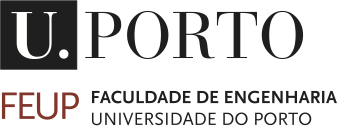   
<h1> <b>Computer Vision 2022/2023 </b> </h1>
<p><b>Andry Maykol Pinto </b> (amgp@fe.up.pt)</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# CNN for Image Classification in Pytorch

## Introduction
Training an image classifier with PyTorch is a task that needs to complete the following steps:

1. Load the data.
2. Define a Convolution Neural Network.
3. Define a Loss function.
4. Train the model on the training data.
5. Test the network on the test data.



# Download Dataset

CIFAR-10 includes 50,000 train and 10,000 test images. They are all natural images, in color, 32 x 32 pixels in size.  In the CIFAR10 dataset, there are ten classes of labels. It is possible to specify a particular subset of a downloaded dataset (e.g. train, val, or test). The syntax is simple and varies only a little depending on the dataset you are using. The necessary arguments to specify a particular subset of a downloaded dataset are all documented here, on the [torchvision datasets page](https://pytorch.org/vision/stable/datasets.html), for each dataset separately.

For more information: 
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

* https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
#include libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cpu device


In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
# batch of images used in each backpropagation step
batch_size = 128

# to be discussed later
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


# Training dataset  : acquire and load
cifar10_train = torchvision.datasets.CIFAR10('cifar10_root/train/', train=True, download=True, transform=transform)
# Test dataset  : acquire and load
cifar10_test = torchvision.datasets.CIFAR10('cifar10_root/test/', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Using Built-In PyTorch Image Datasets with the DataLoader Class

In [5]:
# Dataloaders linked to datasets
trainloader = torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

#Name of classes (10 classes)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

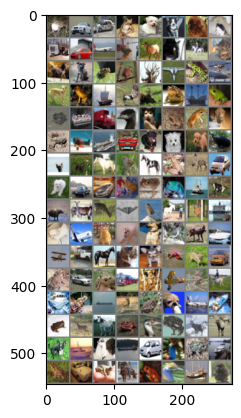

frog  car   car   frog  dog   dog   dog   dog   truck car   plane bird  horse cat   horse cat   horse dog   frog  bird  deer  plane frog  plane dog   frog  ship  bird  deer  frog  ship  frog  frog  ship  truck bird  cat   frog  frog  dog   frog  plane ship  car   dog   dog   dog   bird  bird  cat   horse bird  horse frog  deer  car   dog   car   car   cat   frog  frog  ship  deer  deer  deer  deer  plane bird  horse deer  ship  dog   plane cat   dog   dog   bird  dog   ship  plane truck horse cat   dog   plane dog   car   frog  car   frog  truck deer  plane frog  horse plane frog  ship  deer  frog  dog   plane ship  frog  deer  horse frog  bird  frog  deer  deer  dog   ship  cat   ship  car   bird  frog  ship  frog  car   frog  horse frog  bird  ship  bird 


In [7]:
#Show some of the training images.
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[j]:5s}' for j in labels))

# Defining a CNN model

In PyTorch, a neural network model is defined as a class that is derived from the `nn.Module` base class. This package contains modules, extensible classes and all the required components to build neural networks.

The CNN is a feed-forward network that will process the input through all the layers during the training stage from which it will compute the loss to understand how far the predicted label of the image is falling from the correct one, and propagate the gradients back into the network to update the weights of the layers. In this way, the network will ''learn'' to set its weights to achieve the best results by iterating over a huge dataset of inputs.

The $\color{green}{forward function}$ (which needs to be declared in Pytorch) computes the value of the loss function, and the $\color{green}{backward function}$ (**does not** need to be explicitly defined in Pytorch) computes the gradients of the learnable parameters. 

The following layer types can be explored in the CNN model:

* The `ReLU layer` is an activation function.
* The `BatchNorm2d` layer, which applies normalization on the inputs to have zero mean and unit variance and increase the network accuracy.
* The `MaxPool layer` will help us to ensure that the location of an object in an image will not affect the ability of the neural network to detect its specific features.
*The `Linear layer` is final layers in our network, which computes the scores of each of the classes and the label with the highest score will be the one model predicts (remember: it is a classification problem!). In the linear layer, the number of input features and the number of output features which should correspond to the number of classes must be specified.


In this example, a CNN class must define the layers in the network, and provide a forward method. 


In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Network()

# Defining a Loss function

The neural network package of Pytorch contains various loss functions for computing a value that estimates how far away the output is from the target. Loss value gives information about the model behaviour after each iteration of the optimization technique used in trainning which is a different concept from model accuracy. The accuracy of the model is calculated on the test data and shows the percentage of the right prediction.

The main objective of the training process is to reduce the loss function's value by changing the weight vector values through backpropagation in neural networks. Learning rate (lr) sets the control of how much you are adjusting the weights of our network with respect the loss gradient.


Consider the Classification loss function based on Cross-Entropy loss and an 
SGD Optimizer.




In [9]:
from torch.optim import Adam, SGD, NAdam
 
# Define the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

# Define the optimizer
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9)

# Prepare the model Training


To train the model, you have to loop over our data iterator, feed the inputs to the network, and optimize. PyTorch doesn’t have a dedicated library for GPU use, but you can manually define the execution device. The device will be an Nvidia GPU if exists on your machine, or your CPU if it does not.

----------------
## Exercise 1:
Complete the training procedure, per epoch, of a CNN model. Follow the function prototype.

In [10]:
from torch.autograd import Variable

# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model: torch.nn.Module, 
          dataloader: torch.utils.data.DataLoader, 
          loss_fn: torch.nn.Module, 
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs, 
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = 0.0
    best_epoch = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        train_acc = 0.0
        train_loss = 0.0
        for ibatch, (images, labels) in enumerate(dataloader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            
            # 1. Forward pass
            y_pred = model(images)

            # 2. Calculate  and accumulate loss
            loss = foss_fn(y_pred,labels)
            train_loss += loss.item() 

            # 3. Optimizer zero grad
            #...

            # 4. Loss backward
            # ...

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch 
        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)

        # we want to save the model if the accuracy is the best

        path = "./myModel_" +str(epoch)+ ".pth"
        saveModel(model, path = path)


        if train_acc > best_accuracy:
            path = str(path_model)
            saveModel(model, path = path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            if verbatim:
              print('Best Epoch #', epoch,' Loss=', best_loss, " Accu=", best_accuracy )

    return best_loss, best_accuracy, best_epoch

--------------------------------

# Prepare the model Testing

Now, you can test the model with batch of images from our test set.

In [11]:
# Function to test the model with a batch of images and show the labels predictions
def testBatch(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader,
              device: torch.device,
              verbatim):
    model.eval()
    y_pred = []
    y_true = []   

    # get batch of images from the test DataLoader  
    images, labels = next(iter(dataloader))

    # get the inputs
    images = Variable(images.to(device))
    labels = Variable(labels.to(device))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    outputs = F.softmax(outputs, dim=-1)

    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    y_pred.extend(predicted.view(-1).detach().cpu().numpy()) # Save Prediction
    y_true.extend(labels.view(-1).detach().cpu().numpy()) # Save Truth
    

    if verbatim :
      # Let's show the predicted labels on the screen to compare with the real ones   
      print('Predicted: ',' '.join(f'{classes[j]:5s}' for j in predicted.cpu().numpy()))
    
      # show all images as one image grid
      imshow(torchvision.utils.make_grid(images.cpu()))
   
      # Show the real labels on the screen 
      print('Real labels: ',' '.join(f'{classes[j]:5s}' for j in labels.cpu().numpy()))
    
    return y_true, y_pred


def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():

        for (x, y) in iterator:
            x = x.to(device)
            y_pred  = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs


-------------
## Exercise 2:
Complete the testing procedure for the CNN model. Follow the function prototype.

In [ ]:

# Function to test the model with the test dataset and print the accuracy for the test images
def test(model: torch.nn.Module, 
         dataloader: torch.utils.data.DataLoader, 
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim = True):
    
    # Put model in eval mode
    #....

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    pred_labels = []
    with torch.no_grad():
        for data in dataloader:

            # get the inputs
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
  
            # 1. run the model on the test set to predict labels
            y_pred = model(images)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc +=  (y_pred_class == labels).sum().item()/len(y_pred_class)
            pred_labels = y_pred_class.tolist()

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    if verbatim:
      print("Loss =", test_loss, "  Accuracy=", test_acc)
    return pred_labels, test_loss, test_acc


----------------

# Training the CNN and testing the model's performance

In [ ]:
if __name__ == "__main__":
    
    model = model.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model, 
                                                    dataloader=trainloader, 
                                                    loss_fn=loss_fn, 
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 40,
                                                    path_model = str("./myModel_best.pth"), 
                                                    verbatim = True)

Best Epoch # 0  Loss= 2.2254256705188995  Accu= 0.16676390664961638
Best Epoch # 1  Loss= 1.7734964579877341  Accu= 0.35342071611253195
Best Epoch # 2  Loss= 1.5203868300103776  Accu= 0.4454403772378517
Best Epoch # 3  Loss= 1.4150403207525268  Accu= 0.4902054028132992
Best Epoch # 4  Loss= 1.3354598396574444  Accu= 0.518310421994885
Best Epoch # 5  Loss= 1.2635227658254715  Accu= 0.5482416879795396
Best Epoch # 6  Loss= 1.2040864087431633  Accu= 0.5713794757033248
Best Epoch # 7  Loss= 1.1570981943698795  Accu= 0.5885310102301791
Best Epoch # 8  Loss= 1.108069544558025  Accu= 0.6064418158567775
Best Epoch # 9  Loss= 1.0700121953359345  Accu= 0.6212715792838875
Best Epoch # 10  Loss= 1.0346506445304207  Accu= 0.6336956521739131
Best Epoch # 11  Loss= 0.9919664890260038  Accu= 0.6494485294117647
Best Epoch # 12  Loss= 0.959519828524431  Accu= 0.6621243606138107
Best Epoch # 13  Loss= 0.9358683347397143  Accu= 0.6696331521739131
Best Epoch # 14  Loss= 0.9047005072883938  Accu= 0.68389146

In [ ]:
    print('Finished Training')
    # Test which classes performed well
    y_pred, test_loss, test_acc  = test(model=model, 
                                        dataloader=testloader, 
                                        loss_fn=loss_fn, 
                                        device=device, 
                                        verbatim = True)

Finished Training
Loss = 1.3611731340613547   Accuracy= 0.6395371835443038


# Loading the model

In [ ]:
    # Load the model we just created
    model = Network()
    model = model.to(device)

    path = "myModel_best.pth"
    model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Analyze the results

A $\color{green}{confusion\text{ } matrix}$ can be used to evaluate the performance of the classification model for 10 classes.

-------------
## Exercise 3:

Calculate the confusion matrix for the predictions obtained by the CNN model that was prepared.

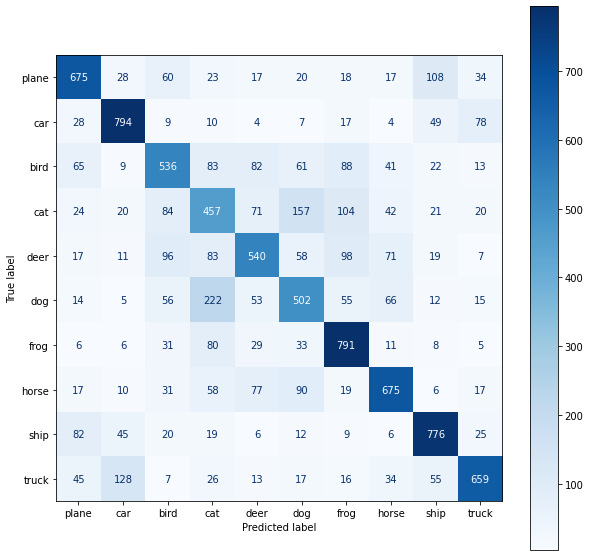

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    #cm = confusion_matrix...
    #cm = ConfusionMatrixDisplay...
    cm.plot(values_format='d', cmap='Blues', ax=ax)

# Test the model using all testset
images, labels, probs = get_predictions(model, testloader,  device)
pred_labels = torch.argmax(probs, 1)    
    
#plot_confusion_matrix...

-------------------------

----------------
## Exercise 4:

A new CNN model needs to be built. 

a) Implement a new CNN model with the following architecture:
1. Conv2d(... out_channels=12, kernel_size=5,...)
2. BatchNorm2d(12)
3. Conv2d(... out_channels=12, kernel_size=5, ...)
4. BatchNorm2d(12)
5. MaxPool2d(2,2)
6. Dropout2d with probability = 0.2
7. Conv2d(... out_channels=24, kernel_size=5 ...)
8. BatchNorm2d(24)
9. Conv2d(... out_channels=24, kernel_size=5...)
10. BatchNorm2d(24)
11. Linear(..., 120)
12. Linear(..., 84)
13. Linear(..., 10)

b) Train the previous model and calculate the confusion matrix for the testdataset. 

c) Compare the performance of the model when trained with different optimizers eg., ADAM, SGD, NADAM.


In [ ]:
#a)

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # ...

    def forward(self, input):
        # ...
        return output

# Instantiate a neural network model 
model = Network()

In [ ]:
#b)

# train
#...


# test and confusion matrix
#...

------------
# Data Augmentation

$\color{yellow}{The \text{ }curse\text{ } of\text{ } data}$:
deep learning models require a large amount of data for training in order to obtain good performances. Acquiring large datasets is costly and challenging (e.g., manual annotations).

Data augmentation involves techniques used for increasing the amount of data. These techniques apply different modifications to images in order to expand the number of samples in the original dataset. 

> Data augmentation has two main objectives: 
1. gowing the dataset. 
2. increasing the diversity of the dataset.


There are multiple ways of performing data augmentation but is not clear what is the most effective way to do it.

$\color{green}{Image\text{ } Augmentation\text{ } techniques}:$
* Resize
* Gray Scale
* Normalize
* Random Rotation
* Center Crop
* Random Crop
* Gaussian Blur
* Gaussian Noise
* Random Blocks
* Central Region
* ...




## Data augmentation in Pytorch

Augmenting data with PyTorch is possible due to Torchvision package which provides several transforms that can be applied in [`torchvision.transforms`](https://pytorch.org/vision/main/transforms.html).

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

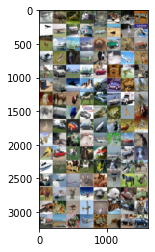

In [ ]:
# Resizing images to 200x200
resized_imgs = transforms.Resize(size=[200, 200])(images) 
# show images
imshow(torchvision.utils.make_grid(resized_imgs))

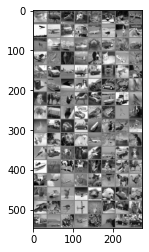

In [ ]:
# Convert to Grayscale image
gray_imgs = transforms.Grayscale()(images) 
# show images
imshow(torchvision.utils.make_grid(gray_imgs))

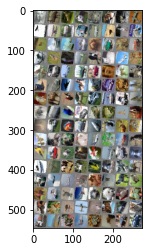

In [ ]:
# Random Rotation between a range
rrotated_imgs = transforms.RandomRotation(degrees=(-90, 90))(images)
# show images
imshow(torchvision.utils.make_grid(rrotated_imgs))

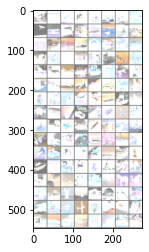

In [ ]:
# Inverts the colors of the given image randomly
rinvert_imgs = transforms.RandomInvert(0.9)(images)
# show images
imshow(torchvision.utils.make_grid(rinvert_imgs))

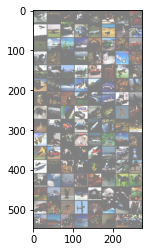

In [ ]:
# Adjust the sharpness of the image randomly with a given probability.
rsharp_imgs = transforms.RandomAdjustSharpness(2, 0.9)(images)
# show images
imshow(torchvision.utils.make_grid(rsharp_imgs))

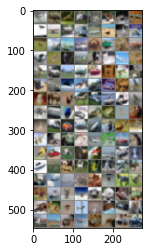

In [ ]:
# Gaussian blur transform to the image using a Gaussian kernel.
blur_imgs = transforms.GaussianBlur(kernel_size=(5, 5), sigma=3)(images)
# show images
imshow(torchvision.utils.make_grid(blur_imgs))


Data augmentation usually needs several transformations that can be putted together using [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html) and then passed as a list. The transforms are applied following the list order to the original images at every batch generation. Therefore, the training dataset is left unchanged since only the batch images are copied and transformed every iteration. 


> The [`transforms.ToTensor`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor) converts images to a PyTorch Tensor and [`transforms.Normalize`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) normalizes images. Both are often used **during the training step**.

----------------
## Exercise 5:

Prepare the transformations to be applied on CIFAR dataset for data augmentation:
 * ColorJitter
 * RandomHorizontalFlip
 * GaussianBlur
 * RandomVerticalFlip
 * RandomRotation

In [ ]:
import PIL
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(17)

transforms_augmented = torchvision.transforms.Compose([
    # ...
    # ...
])

The `transforms` are passed to `torchvision.datasets.ImageFolder` which will automatically augment images. 

In [ ]:
#dataset_augmented = torchvision.datasets.ImageFolder('path_dataset/data/', transform=transforms)
cifar_trainset_augmented = torchvision.datasets.CIFAR10('cifar10_root/train_augmented/', train=True, download=True, transform=transforms_augmented)

Files already downloaded and verified


Visualizing a batch of augmented images:

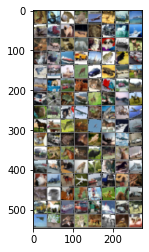

deer  bird  frog  bird  plane deer  ship  ship  plane truck dog   deer  frog  truck horse ship  deer  deer  cat   dog   dog   dog   ship  dog   cat   bird  ship  car   ship  frog  cat   truck plane plane ship  deer  car   frog  plane deer  deer  dog   truck cat   cat   truck truck plane car   bird  frog  ship  deer  deer  plane horse bird  deer  cat   plane frog  truck cat   plane horse horse deer  frog  plane horse ship  ship  cat   truck frog  deer  bird  plane plane car   truck frog  horse frog  bird  deer  deer  plane ship  truck cat   bird  bird  frog  horse ship  cat   plane dog   plane ship  truck dog   frog  frog  bird  dog   deer  horse frog  deer  truck truck horse ship  truck truck plane car   horse plane cat   cat   cat   horse horse bird  frog 


In [ ]:
#Dataloader for Augmented dataset
trainloader_aug = torch.utils.data.DataLoader(cifar_trainset_augmented, batch_size=batch_size, shuffle=True, num_workers=2)

# get some random training images
dataiter = iter(trainloader_aug)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[j]:5s}' for j in labels))

## Training the model with data augmentation

The model can be (re)trained using the `trainloader_aug` dataloader.

In [ ]:
# Load the model we just created
model_aug = Network()
model_aug = model.to(device)

# Train our model using the "trainloader"
best_loss, best_accuracy, best_epoch = train(model=model_aug, 
                                                    dataloader=trainloader, 
                                                    loss_fn=loss_fn, 
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 20,
                                                    path_model = str("./myModel_best_aug.pth"), 
                                                    verbatim = True) 

# Load best model
model_aug.load_state_dict(torch.load("myModel_best_aug.pth"))

# Train our model using the "trainloader_aug"
best_loss, best_accuracy, best_epoch = train(model=model_aug, 
                                                    dataloader=trainloader_aug, 
                                                    loss_fn=loss_fn, 
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 20,
                                                    path_model = str("./myModel_best_aug.pth"), 
                                                    verbatim = True)



print('Finished Training')

Best Epoch # 0  Loss= 0.3835410353015451  Accu= 0.8654691496163683
Best Epoch # 3  Loss= 0.3836171574833448  Accu= 0.8654811381074169
Best Epoch # 15  Loss= 0.38356639993617603  Accu= 0.8654931265984654
Best Epoch # 19  Loss= 0.38361169912321186  Accu= 0.8655051150895141
Best Epoch # 0  Loss= 1.4484958798074357  Accu= 0.5590912723785166
Best Epoch # 1  Loss= 1.449910312357461  Accu= 0.5598625319693095
Best Epoch # 2  Loss= 1.4423169165925906  Accu= 0.5611772698209718
Best Epoch # 5  Loss= 1.4439905406264089  Accu= 0.5622282608695652
Best Epoch # 8  Loss= 1.4309677175243798  Accu= 0.5654611572890026
Finished Training


Loss = 1.335365592678891   Accuracy= 0.6410205696202531


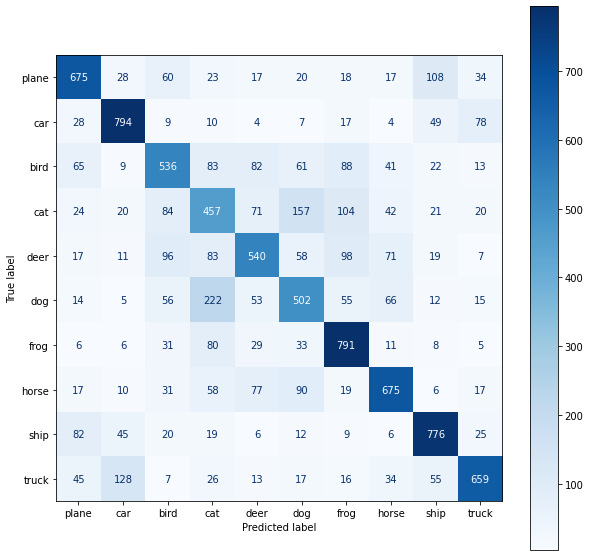

In [ ]:
# Load best model
model_aug.load_state_dict(torch.load("myModel_best_aug.pth"))


# Test which classes performed well
y_pred, test_loss, test_acc  = test(model=model_aug, 
                                    dataloader=testloader, 
                                    loss_fn=loss_fn, 
                                    device=device, 
                                    verbatim = True)

# Test the model using all testset
images, labels, probs = get_predictions(model_aug, testloader,  device)
pred_labels = torch.argmax(probs, 1)    

# Print Confusion Matrix    
plot_confusion_matrix(labels, pred_labels)